In [3]:
import os

import pandas as pd
import numpy as np
import itertools
import geopandas as gpd

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
from matplotlib.lines import Line2D
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.transforms import ScaledTranslation

# TODO:
# * Short the legend following the color code

plt.rcParams['legend.handlelength'] = 1
plt.rcParams['legend.handleheight'] = 1.125
plt.rcParams["font.family"]         = "Avenir"
mpl.rcParams['pdf.fonttype'] = 42

mpl.rcParams.update({"pdf.use14corefonts": True})

path_to_scenarios = '/Users/Guille/Desktop/india_power/scenarios'
path_to_images    = '/Users/Guille/Desktop/india_power/images'
path_to_csvs      = '/Users/Guille/Desktop/india_power/gridpath_india_viz/csvs'

In [4]:
# Grab data from databases for plotting new and existing capacity
def _load_capacity(scen_labels_):

    # Load project capacity table and process them from database
    def __load_new_and_existing_csv(df_, scenario):

        df_['capacity_mw'] = df_['capacity_mw'].astype(float)
        df_['status']      = 'new'
        df_                = df_[['project', 
                                  'period', 
                                  'technology', 
                                  'load_zone', 
                                  'status', 
                                  'capacity_mw', 
                                  'energy_capacity_mwh']]

        idx_  = (df_['period'] == 2020) & (df_['capacity_mw'] != 0.)
        df_.loc[capacity_['project'].isin(df_.loc[idx_, 'project'].unique()), 'status'] = 'existing'
        
        df_ = df_.groupby(['period', 
                           'technology', 
                           'load_zone',
                           'status']).agg({'capacity_mw': 'sum', 
                                           'energy_capacity_mwh': 'sum'})

        df_ = df_.reset_index(drop = False).rename(columns = {'energy_capacity_mwh': 'capacity_mwh'})

        df_['scenario'] = scenario

        return df_
    
    dfs_ = []
    # Open connection: open database and grab meta-data
    for scen, path in zip(scen_labels_['scenario'],  scen_labels_['path']):
        print(scen, path)
        dir_name  = r'{}/{}'.format(path, scen)
        capacity_ = pd.read_csv(dir_name + r'/results/project_period.csv', low_memory = False)
        df_       = __load_new_and_existing_csv(capacity_, scen)
        
        # Load specified capacity from csv files
        dfs_.append(df_)

    return pd.concat(dfs_, axis = 0).reset_index(drop = True)

# Grab data from databases for plotting energy dispatch and clean energy targets
def _load_dispatch(scen_labels_):

    # Load energy dispatch table and process data from database
    def __load_dispatch_from_csv(df_, scenario, zone):
        
        df_['power_mw'] = df_['number_of_hours_in_timepoint']*df_['timepoint_weight']*df_['power_mw']

        df_ = df_[['period', 'technology', 'load_zone', 'power_mw']]
            
        df_ = df_.groupby(['period', 
                           'technology', 
                           'load_zone']).agg({'power_mw': 'sum'}).reset_index(drop = False)
        
        df_['scenario'] = scenario
                
        return df_
        
    # Load energy dispatch table and process data from database
    def __load_demand_from_csv(df_, scenario, zone):
        
        df_['overgeneration_mw']  = df_['number_of_hours_in_timepoint']*df_['timepoint_weight']*df_['overgeneration_mw']
        df_['unserved_energy_mw'] = df_['number_of_hours_in_timepoint']*df_['timepoint_weight']*df_['unserved_energy_mw']
        
        df_1_               = df_[['period', 'load_zone', 'overgeneration_mw']].copy()
        df_1_['technology'] = 'Curtailment'                
        df_1_               = df_1_.rename(columns = {'overgeneration_mw': 'power_mw'})

        df_2_               = df_[['period', 'load_zone', 'unserved_energy_mw']].copy()
        df_2_['technology'] = 'Shedding'                 
        df_2_               = df_2_.rename(columns = {'unserved_energy_mw': 'power_mw'})

        df_ = pd.concat([df_1_, df_2_], axis = 0)
            
        df_ = df_.groupby(['period', 
                           'technology', 
                           'load_zone']).agg({'power_mw': 'sum'}).reset_index(drop = False)
        
        df_['scenario'] = scenario
                                  
        return df_

    def __load_tx_losses_from_csv(df_, scenario, zone):
        
        df_['transmission_losses_lz_to']   = - df_['number_of_hours_in_timepoint']*df_['timepoint_weight']*df_['transmission_losses_lz_to'] 
        df_['transmission_losses_lz_from'] = - df_['number_of_hours_in_timepoint']*df_['timepoint_weight']*df_['transmission_losses_lz_from']

        df_1_               = df_[['period', 'load_zone_to', 'transmission_losses_lz_to']].copy()
        df_1_['technology'] = 'Tx_Losses'
        df_1_               = df_1_.rename(columns = {'transmission_losses_lz_to': 'power_mw', 
                                                      'load_zone_to': 'load_zone'})

        df_2_               = df_[['period', 'load_zone_from', 'transmission_losses_lz_from']].copy()
        df_2_['technology'] = 'Tx_Losses'
        df_2_               = df_2_.rename(columns = {'transmission_losses_lz_from': 'power_mw',
                                                      'load_zone_from': 'load_zone'})
        
        df_ = pd.concat([df_1_, df_2_], axis = 0)
        
        df_ = df_.groupby(['period', 
                           'technology', 
                           'load_zone']).agg({'power_mw': 'sum'}).reset_index(drop = False)

        df_['scenario'] = scenario
        
        return df_

    dfs_ = []
    # Open connection: open database and grab meta-data
    for scenario, zone, path in zip(scen_labels_['scenario'], scen_labels_['zone'], scen_labels_['path']):
        print(scenario, zone, path)
        
        dir_name   = r'{}/{}'.format(path, scenario)
        dispatch_  = pd.read_csv(dir_name + f'/results/project_timepoint.csv', low_memory = False)
        demand_    = pd.read_csv(dir_name + f'/results/system_load_zone_timepoint.csv', low_memory = False)
        tx_losses_ = pd.read_csv(dir_name + f'/results/transmission_timepoint.csv', low_memory = False)
        
        dfs_ += [__load_tx_losses_from_csv(tx_losses_, scenario, zone)]
        dfs_ += [__load_demand_from_csv(demand_, scenario, zone)]
        dfs_ += [__load_dispatch_from_csv(dispatch_, scenario, zone)]

    return pd.concat(dfs_, axis = 0).reset_index(drop = True)

In [5]:
def _group_capacity_technologies(capacity_, tech_labels_):

    for group in tech_labels_['group'].unique():
        capacity_.loc[capacity_['technology'].isin(tech_labels_.loc[tech_labels_['group'] == group, 'technology']), 'technology'] = group
        
    capacity_ = capacity_.groupby(['period', 
                                   'technology', 
                                   'load_zone', 
                                   'status', 
                                   'scenario']).agg({'capacity_mw': 'sum', 
                                                     'capacity_mwh': 'sum'})

    return capacity_.reset_index(drop = False)

def _group_dispatch_technologies(df_, tech_labels_):

    for group in tech_labels_['group'].unique():
        df_.loc[df_['technology'].isin(tech_labels_.loc[tech_labels_['group'] == group, 'technology']), 'technology'] = group
        
    df_ = df_.groupby(['period', 
                       'technology', 
                       'load_zone', 
                       'scenario']).agg({'power_mw': 'sum'})

    return df_.reset_index(drop = False)

In [6]:
def _plot_new_and_existing_capacity(ax, df_, scens_label_, tech_label_, 
                                    units        = 1e3,
                                    units_label  = 'Existing & New Capacity (GW)',
                                    y_period_loc = -1600.,
                                    y_grid_inc   = 500,
                                    div_line_len = 0.325,
                                    legend       = True,
                                    title        = ''):

    def __make_new_and_existing_capacit_legend(df_, techs_, colors_, ax):

        ax.bar(0., 0., 0., bottom    = 0.,
                           label     = 'Existing',
                           color     = 'None',
                           lw        = 0.,
                           hatch     = 'xx',
                           edgecolor = 'lightgray',
                           zorder    = 10)

        for tech, i_tech in zip(techs_, range(len(techs_))):
            idx_ = df_['technology'] == tech
            if idx_.sum() > 0:
                if df_.loc[idx_, 'capacity_mw'].sum() != 0:
                    ax.bar(0., 0., 0., bottom = 0.,
                                       color  = colors_[i_tech],
                                       label  = tech,
                                       zorder = 10)

    periods_     = np.sort(df_['period'].unique())
    scens_       = scens_label_['scenario'].unique()    
    techs_, idx_ = np.unique(tech_label_['group'], return_index = True)
    colors_      = tech_label_.loc[tech_label_.index[idx_], 'group_color'].to_list()

    ticks_    = []
    labels_   = []
    offsets_  = []
    lengths_  = []
    x_period_ = []
    
    i_scen = 0
    offset = 0
    y_max  = 0
    
    width  = 1/(len(scens_) + 1)
    x_     = np.linspace(0, len(periods_) - 1, len(periods_))
    
    for scen, label, zone in zip(scens_label_['scenario'], scens_label_['label'], scens_label_['zone']):

        df_p_ = df_.copy()
        
        if (df_p_['load_zone'] == zone).sum() == 0.:
            df_p_['load_zone'] = zone
            df_p_ = df_p_.groupby(['period', 
                                   'technology', 
                                   'load_zone', 
                                   'status',
                                   'scenario']).agg({'capacity_mw': 'sum'}).reset_index(drop = False)
            
        idx_ = (df_p_['scenario'] == scen) & (df_p_['load_zone'] == zone)
                
        for period, i_period in zip(periods_, range(len(periods_))):
            idx_1_ = idx_ & (df_p_['period'] == period)
            if (i_scen == 0) & (i_period == 0): 
                __make_new_and_existing_capacit_legend(df_p_, techs_, colors_, ax)

            for tech, i_tech in zip(techs_, range(len(techs_))):
                idx_2_ = idx_1_ & (df_p_['status'] == 'existing') & (df_p_['technology'] == tech)

                if idx_2_.sum() == 1.:
                    power = df_p_.loc[idx_2_, 'capacity_mw'].to_numpy()[0]
                    color = tech_label_.loc[tech_label_['group'] == tech, 'group_color'].unique()

                    ax.bar(x_[i_period], power/units, width, bottom    = offset/units,
                                                             color     = color,
                                                             lw        = 0.,
                                                             hatch     = 'x',
                                                             edgecolor = 'lightgray', zorder = 10)

                    offset += power

            for tech, i_tech in zip(techs_, range(len(techs_))):
                idx_3_ = idx_1_ & (df_p_['technology'] == tech) & (df_p_['status'] == 'new')
                if idx_3_.sum() == 1.:
                    power = df_p_.loc[idx_3_, 'capacity_mw'].to_numpy()[0]
                    color = tech_label_.loc[tech_label_['group'] == tech, 'group_color'].unique()

                    ax.bar(x_[i_period], power/units, width, bottom = offset/units,
                                                             color  = color,
                                                             zorder = 10)

                    offset += power

            if y_max < offset:
                y_max = offset

            ticks_.append(x_[i_period])
            labels_.append(label)
            offsets_.append(offset/units)
            x_period_.append(x_[i_period])

            offset = 0.

        x_ = x_ + .9/len(scens_)
        i_scen += 1
        
    z_ = x_ - .9/len(scens_)

    x_period_ = np.mean(np.array(x_period_).reshape(len(scens_), len(periods_)), axis = 0)
    y_period_ = np.max(np.array(offsets_).reshape(len(scens_), len(periods_)), axis = 0)
    
    for x_period, y_period, period in zip(x_period_, y_period_, periods_):
        ax.text(x_period, y_period_loc, period, fontsize            = 18, 
                                                 weight              = 'bold',
                                                 horizontalalignment = 'center', 
                                                 verticalalignment   = 'center')

    x_ = np.linspace(0, len(periods_), len(periods_) + 1)
    dz = (x_[1] - z_[0])
    for x in x_:
        ax.axvline(x - dz/2., ymin      = 0.,
                              ymax      = - div_line_len,
                              linewidth = .75,
                              linestyle = '-',
                              color     = 'k',
                              clip_on   = False,
                              zorder    = 10)

    N_steps  = int(np.ceil((y_max/units)/y_grid_inc))
    y_ticks_ = np.linspace(0, int(N_steps*y_grid_inc), N_steps + 1, dtype = int)

    ax.set_xticks(ticks_, labels_, rotation = 90)

    ax.xaxis.set_tick_params(labelsize = 12, 
                             left      = False)
    
    ax.yaxis.set_tick_params(labelsize = 12, 
                             left      = False)

    ax.set_ylabel(units_label, fontsize = 18)
    ax.set_yticks(y_ticks_, y_ticks_)

    if legend:
        ax.legend(loc            = 'center left',
                  bbox_to_anchor = (1, 0.5),
                  frameon        = False,
                  prop           = {'size': 12})

    ax.set_ylim(-10., y_period_.max()*1.2)
    ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))

    ax.set_title(title, fontsize = 20,
                     y        = 0.912)

    ax.spines[['right', 'top', 'left', 'bottom']].set_visible(False)
    ax.grid(axis = 'y')
    
def _plot_new_and_existing_storage(ax, df_, scens_label_, tech_label_, 
                                   units        = 1e3,
                                   units_label  = 'Existing & New Capacity (GW)',
                                   y_period_loc = -6250.,
                                   y_grid_inc   = 2000,
                                   div_line_len = 0.325,
                                   legend       = True,
                                   title        = ''):

    def __make_new_and_existing_capacit_legend(df_, techs_, colors_, ax):

        ax.bar(0., 0., 0., bottom    = 0.,
                           label     = 'Existing',
                           color     = 'None',
                           lw        = 0.,
                           hatch     = 'xx',
                           edgecolor = 'lightgray',
                           zorder    = 10)

        for tech, i_tech in zip(techs_, range(len(techs_))):
            idx_ = df_['technology'] == tech
            if idx_.sum() > 0:
                if df_.loc[idx_, 'capacity_mwh'].sum() != 0:
                    ax.bar(0., 0., 0., bottom = 0.,
                                       color  = colors_[i_tech],
                                       label  = tech,
                                       zorder = 10)

    periods_     = np.sort(df_['period'].unique())
    scens_       = scens_label_['scenario'].unique()    
    techs_, idx_ = np.unique(tech_label_['group'], return_index = True)
    colors_      = tech_label_.loc[tech_label_.index[idx_], 'group_color'].to_list()

    ticks_    = []
    labels_   = []
    offsets_  = []
    lengths_  = []
    x_period_ = []
    
    i_scen = 0
    offset = 0
    y_max  = 0
    
    width  = 1/(len(scens_) + 1)
    x_     = np.linspace(0, len(periods_) - 1, len(periods_))
    
    for scen, label, zone in zip(scens_label_['scenario'], scens_label_['label'], scens_label_['zone']):

        df_p_ = df_.copy()
        
        if (df_p_['load_zone'] == zone).sum() == 0.:
            df_p_['load_zone'] = zone
            df_p_ = df_p_.groupby(['period', 
                                   'technology', 
                                   'load_zone', 
                                   'status',
                                   'scenario']).agg({'capacity_mwh': 'sum'}).reset_index(drop = False)
            
        idx_ = (df_p_['scenario'] == scen) & (df_p_['load_zone'] == zone)
                
        for period, i_period in zip(periods_, range(len(periods_))):
            idx_1_ = idx_ & (df_p_['period'] == period)
            if (i_scen == 0) & (i_period == 0): 
                __make_new_and_existing_capacit_legend(df_p_, techs_, colors_, ax)

            for tech, i_tech in zip(techs_, range(len(techs_))):
                idx_2_ = idx_1_ & (df_p_['status'] == 'existing') & (df_p_['technology'] == tech)

                if idx_2_.sum() == 1.:
                    power = df_p_.loc[idx_2_, 'capacity_mwh'].to_numpy()[0]
                    color = tech_label_.loc[tech_label_['group'] == tech, 'group_color'].unique()

                    ax.bar(x_[i_period], power/units, width, bottom    = offset/units,
                                                             color     = color,
                                                             lw        = 0.,
                                                             hatch     = 'x',
                                                             edgecolor = 'lightgray', zorder = 10)

                    offset += power

            for tech, i_tech in zip(techs_, range(len(techs_))):
                idx_3_ = idx_1_ & (df_p_['technology'] == tech) & (df_p_['status'] == 'new')
                if idx_3_.sum() == 1.:
                    power = df_p_.loc[idx_3_, 'capacity_mwh'].to_numpy()[0]
                    color = tech_label_.loc[tech_label_['group'] == tech, 'group_color'].unique()

                    ax.bar(x_[i_period], power/units, width, bottom = offset/units,
                                                             color  = color,
                                                             zorder = 10)

                    offset += power

            if y_max < offset:
                y_max = offset

            ticks_.append(x_[i_period])
            labels_.append(label)
            offsets_.append(offset/units)
            x_period_.append(x_[i_period])

            offset = 0.

        x_ = x_ + .9/len(scens_)
        i_scen += 1
        
    z_ = x_ - .9/len(scens_)

    x_period_ = np.mean(np.array(x_period_).reshape(len(scens_), len(periods_)), axis = 0)
    y_period_ = np.max(np.array(offsets_).reshape(len(scens_), len(periods_)), axis = 0)
    
    for x_period, y_period, period in zip(x_period_, y_period_, periods_):
        ax.text(x_period, y_period_loc, period, fontsize            = 18, 
                                                 weight              = 'bold',
                                                 horizontalalignment = 'center', 
                                                 verticalalignment   = 'center')

    x_ = np.linspace(0, len(periods_), len(periods_) + 1)
    dz = (x_[1] - z_[0])
    for x in x_:
        ax.axvline(x - dz/2., ymin      = 0.,
                              ymax      = - div_line_len,
                              linewidth = .75,
                              linestyle = '-',
                              color     = 'k',
                              clip_on   = False,
                              zorder    = 10)

    N_steps  = int(np.ceil((y_max/units)/y_grid_inc))
    y_ticks_ = np.linspace(0, int(N_steps*y_grid_inc), N_steps + 1, dtype = int)

    ax.set_xticks(ticks_, labels_, rotation = 90)

    ax.xaxis.set_tick_params(labelsize = 12, 
                             left      = False)
    
    ax.yaxis.set_tick_params(labelsize = 12, 
                             left      = False)

    ax.set_ylabel(units_label, fontsize = 18)
    ax.set_yticks(y_ticks_, y_ticks_)

    if legend:
        ax.legend(loc            = 'center left',
                  bbox_to_anchor = (1, 0.5),
                  frameon        = False,
                  prop           = {'size': 12})

    ax.set_ylim(-50., )
    ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))

    ax.set_title(title, fontsize = 20,
                        y        = 0.912)

    ax.spines[['right', 'top', 'left', 'bottom']].set_visible(False)
    ax.grid(axis = 'y')

def _plot_dispatch(ax, df_, scens_label_, tech_label_, 
                   units        = 1e6,
                   units_label  = r'Electricity Generation (TWh)',
                   y_period_loc = -3870.,
                   y_grid_inc   = 1000,
                   div_line_len = .425,
                   legend       = True,
                   title        = ''):

    def __make_dispatch_legend(data_, techs_, colors_, ax):
        for tech, i_tech in zip(techs_, range(len(techs_))):
            idx_ = data_['technology'] == tech
            if idx_.sum() > 0:
                if data_.loc[idx_, 'power_mw'].to_numpy().sum() != 0:
                    ax.bar(0., 0., 0., bottom = 0.,
                                       color  = colors_[i_tech],
                                       label  = tech.replace('_', ' '),
                                       zorder = 2,
                                       ec     = 'None',
                                       lw     = 0.,
                                       aa     = True)

    periods_     = np.sort(df_['period'].unique())
    scens_       = scens_label_['scenario'].unique()    
    techs_, idx_ = np.unique(tech_label_['group'], return_index = True)
    colors_      = tech_label_.loc[tech_label_.index[idx_], 'group_color'].to_list()

    width = 1./(len(scens_) + 1)
    x_    = np.linspace(0, len(periods_) - 1, len(periods_))

    ticks_    = []
    labels_   = []
    x_period_ = []
    y_period_ = []
    
    i_scen          = 0
    offset_positive = 0.
    offset_negative = 0.    
    y_max           = 0
    y_min           = 0
    
    for scen, label, zone in zip(scens_label_['scenario'], scens_label_['label'], scens_label_['zone']):
        df_p_ = df_.copy()
        
        if (df_p_['load_zone'] == zone).sum() == 0.:
            df_p_['load_zone'] = zone
            df_p_ = df_p_.groupby(['period', 
                                   'technology', 
                                   'load_zone', 
                                    'scenario']).agg({'power_mw': 'sum'}).reset_index(drop = False)
            
        idx_ = (df_p_['scenario'] == scen) & (df_p_['load_zone'] == zone)

        for period, i_period in zip(periods_, range(len(periods_))):
            idx_1_ = idx_ & (df_p_['period'] == period)
            
            if (i_scen == 0) & (i_period == 0): 
                __make_dispatch_legend(df_p_, techs_, colors_, ax)

                
            for tech, i_tech in zip(techs_, range(len(techs_))):
                idx_2_ = idx_1_ & (df_p_['technology'] == tech)

                if idx_2_.sum() == 1:
                    power = float(df_p_.loc[idx_2_, 'power_mw'].to_numpy()[0])
                    color = tech_label_.loc[tech_label_['group'] == tech, 'group_color'].unique()

                    if power != 0:
                        if power > 0:
                            offset = offset_positive
                        else:
                            offset = offset_negative

                        ax.bar(x_[i_period], power/units, width, bottom = offset/units,
                                                                 color  = color,
                                                                 zorder = 2,
                                                                 ec     = 'None',
                                                                 lw     = 0.,
                                                                 aa     = True)

                        if power >= 0:
                            offset_positive += power
                        else:
                            offset_negative += power

            if offset_negative/units < y_min: 
                y_min = offset_negative/units
            if offset_positive/units > y_max: 
                y_max = offset_positive/units

            ticks_.append(x_[i_period])
            labels_.append(label)
            x_period_.append(x_[i_period])
            y_period_.append(offset_positive)
            
            offset_positive = 0.
            offset_negative = 0.

        x_ = x_ + .9/len(scens_)
        
        i_scen += 1
        
    z_ = x_ - .9/len(scens_)

    x_period_ = np.mean(np.array(x_period_).reshape(len(scens_), len(periods_)), axis = 0)
    y_period_ = np.max(np.array(y_period_).reshape(len(scens_), len(periods_)), axis = 0)

    for x_period, y_period, period in zip(x_period_, y_period_, periods_):
        ax.text(x_period, y_period_loc, period, fontsize            = 18, 
                                                 weight              = 'bold',
                                                 horizontalalignment = 'center', 
                                                 verticalalignment   = 'center')

    ax.set_xticks(ticks_, labels_, rotation = 90)
    ax.xaxis.set_tick_params(labelsize = 12, left = False)

    N_steps  = int(np.ceil(y_max/y_grid_inc))
    y_ticks_ = np.linspace(0, int(N_steps*y_grid_inc), N_steps + 1, dtype = int)

    ax.set_ylabel(units_label, fontsize = 18)
    ax.set_yticks(y_ticks_, y_ticks_)
    ax.yaxis.set_tick_params(labelsize = 12, left = False)

    x_ = np.linspace(0, len(periods_), len(periods_) + 1)
    dz = (x_[1] - z_[0])
    for x in x_:
        ax.axvline(x - dz/2., ymin      = 0.,
                              ymax      = -div_line_len,
                              linewidth = .75,
                              linestyle = '-',
                              color     = 'k',
                              clip_on   = False,
                              zorder    = 10)

    if legend:
        ax.legend(loc            = 'center left',
                  bbox_to_anchor = (1, 0.5),
                  frameon        = False,
                  prop           = {'size': 12})

    ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))

    ax.set_title(title, fontsize = 18,
                        y        = 0.9125)

    ax.spines[['right', 'top', 'left', 'bottom']].set_visible(False)
    ax.grid(axis = 'y')

In [19]:
scen_labels_ = pd.read_csv(path_to_csvs + '/tech_cost-scenario_labels.csv') 
tech_labels_ = pd.read_csv(path_to_csvs + '/technology_labels.csv') 

# Mosaic

In [20]:
dispatch_         = _load_dispatch(scen_labels_)
grouped_dispatch_ = _group_dispatch_technologies(dispatch_, tech_labels_)
capacity_         = _load_capacity(scen_labels_)
grouped_capacity_ = _group_capacity_technologies(capacity_, tech_labels_)

VREmid_STmid_CONVmid_H2_RES_10PRM_CC_50RPS_PIERmid all /Users/Guille/Desktop/india_power/scenarios/policy
VREmid_STmid_CONVmid_H2_RES_10PRM_CC_50RPS_500GW_PIERmid all /Users/Guille/Desktop/india_power/scenarios/policy
VREmid_STmid_CONVmid_H2_RES_10PRM_CC_50RPS_80CAP_500GW_PIERmid all /Users/Guille/Desktop/india_power/scenarios/policy
VREmid_STmid_CONVmid_H2_RES_10PRM_CC_50RPS_90CAP_500GW_PIERmid all /Users/Guille/Desktop/india_power/scenarios/policy
VREmid_STmid_CONVmid_H2_RES_10PRM_CC_50RPS_100CAP_500GW_PIERmid all /Users/Guille/Desktop/india_power/scenarios/policy
VREmid_STmid_CONVmid_H2_RES_10PRM_CC_50RPS_PIERmid /Users/Guille/Desktop/india_power/scenarios/policy
VREmid_STmid_CONVmid_H2_RES_10PRM_CC_50RPS_500GW_PIERmid /Users/Guille/Desktop/india_power/scenarios/policy
VREmid_STmid_CONVmid_H2_RES_10PRM_CC_50RPS_80CAP_500GW_PIERmid /Users/Guille/Desktop/india_power/scenarios/policy
VREmid_STmid_CONVmid_H2_RES_10PRM_CC_50RPS_90CAP_500GW_PIERmid /Users/Guille/Desktop/india_power/scenar

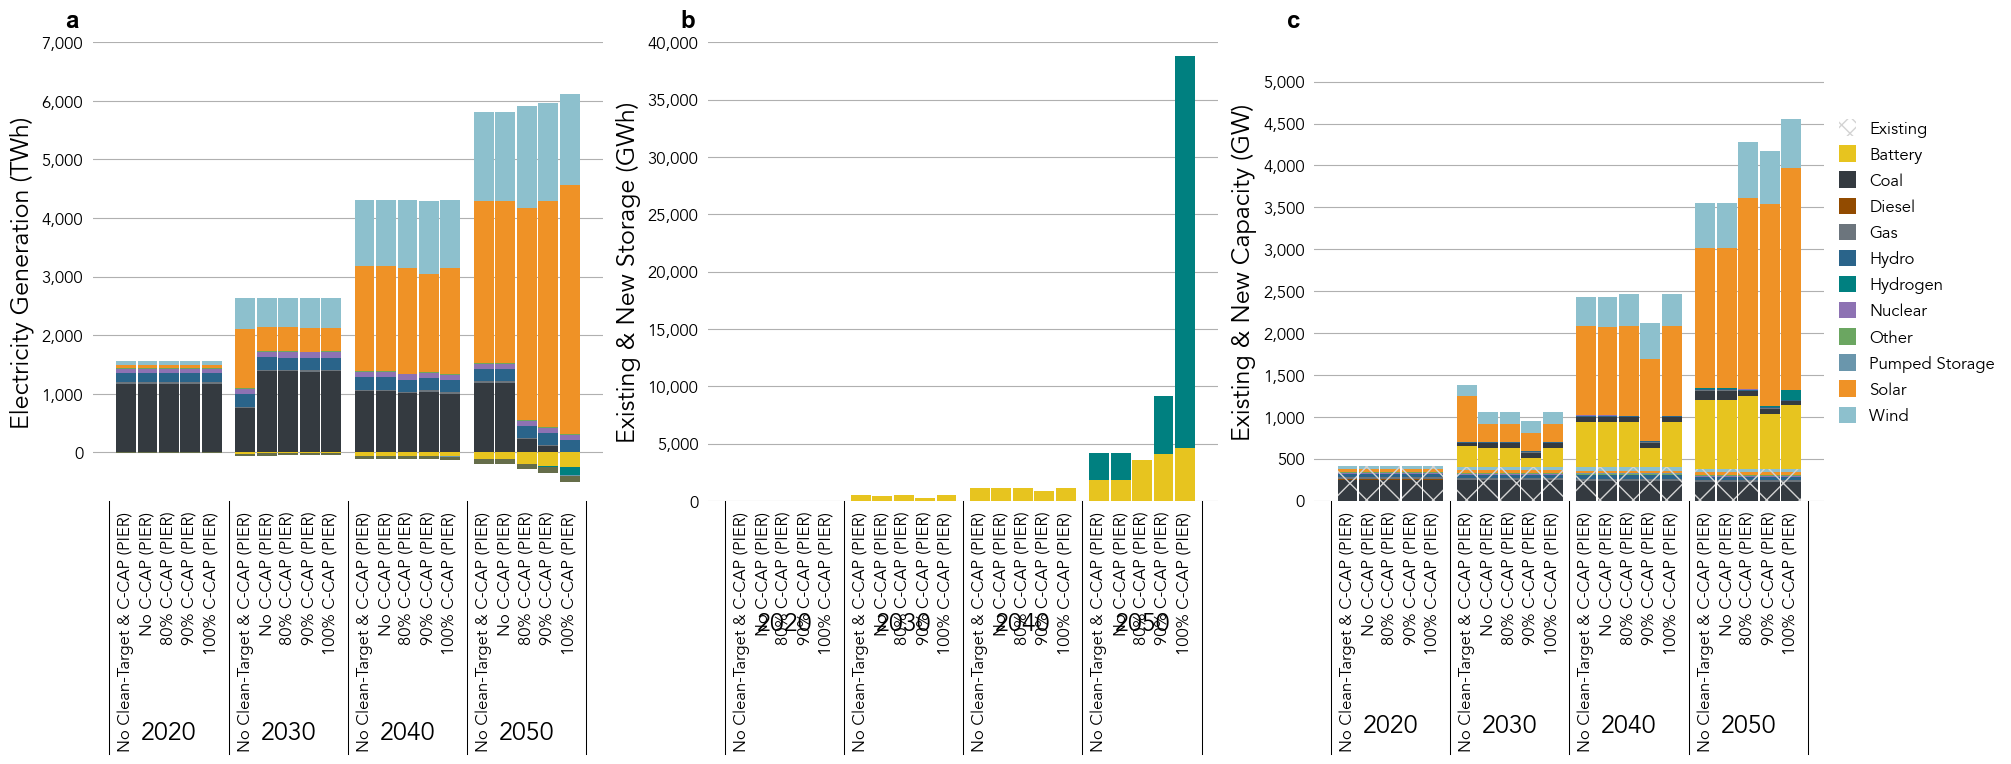

In [21]:
fig, _ax = plt.subplot_mosaic([['a', 'b', 'c']], layout      = 'constrained', 
                                                 figsize     = (20, 7.5), 
                                                 gridspec_kw = {'width_ratios': [1, 1, 1]})

for label, ax in _ax.items():
    ax.text(0.0, 1.0, label, transform = (ax.transAxes + ScaledTranslation(-20/72, +7/72, fig.dpi_scale_trans)),
                             fontsize  = 'xx-large', 
                             weight    = "bold",
                             va        = 'bottom',
                             family    = 'Arial')
    
_plot_dispatch(_ax['a'], grouped_dispatch_, scen_labels_, tech_labels_, 
               units_label  = r'Electricity Generation (TWh)', 
               legend       = False, 
               y_period_loc = -4800.,
               y_grid_inc   = 1000,
               div_line_len = 0.55)

_plot_new_and_existing_storage(_ax['b'], grouped_capacity_, scen_labels_, tech_labels_,
                               units_label  = 'Existing & New Storage (GWh)', 
                               legend       = False,
                               y_period_loc = -10750.,
                               y_grid_inc   = 5000,
                               div_line_len = 0.55)

_plot_new_and_existing_capacity(_ax['c'], grouped_capacity_, scen_labels_, tech_labels_,
                                units_label  = 'Existing & New Capacity (GW)',
                                legend       = True,
                                y_period_loc = -2700.,
                                y_grid_inc   = 500,
                                div_line_len = 0.55)

plt.savefig(path_to_images + '/policy_pier-capacity_generation.png', 
            bbox_inches = 'tight', 
            dpi         = 300)

plt.show()

# Electricity Generation

In [ ]:
dispatch_         = _load_dispatch(scen_labels_)
grouped_dispatch_ = _group_dispatch_technologies(dispatch_, tech_labels_)

fig = plt.figure(figsize = (12.5, 7.5))
_ax = plt.subplot(111)
    
# Enter a title of your choice between the quotation marks ('') under title = ''.
_plot_dispatch(_ax, grouped_dispatch_, scen_labels_, tech_labels_, 
               units_label  = r'Electricity Generation (TWh)')

plt.savefig(path_to_images + r'/group_electricity_generation.png', bbox_inches = 'tight',
                                                                   dpi         = 600)

plt.show()

# New and Existing

In [ ]:
capacity_         = _load_capacity(scen_labels_)
grouped_capacity_ = _group_capacity_technologies(capacity_, tech_labels_)

### Power Capacity

In [ ]:
fig = plt.figure(figsize = (12.5, 10))
_ax = plt.subplot(111)

_plot_new_and_existing_capacity(_ax, grouped_capacity_, scen_labels_, tech_labels_,
                                units_label = 'Existing & New Capacity (GW)')

plt.savefig(path_to_images + r'/group_installed_mw.png', bbox_inches = 'tight', 
                                                               dpi         = 600)
plt.show()


### Energy Capacity

In [ ]:
fig = plt.figure(figsize = (12.5, 10))
_ax = plt.subplot(111)

_plot_new_and_existing_storage(_ax, grouped_capacity_, scen_labels_, tech_labels_,
                               units_label = 'Existing & New Storage (GWh)')

plt.savefig(path_to_images + r'/group_installed_mwh.png', bbox_inches = 'tight', 
                                                          dpi         = 600)
plt.show()